<a href="https://colab.research.google.com/github/devans1907/Deep-Residual-Learning-for-Image-Recognition/blob/main/Deep%20Residual%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
"""
CELL 1: PROJECT DEPENDENCIES - IMPORTING LIBRARIES

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This cell serves as the central hub for all the Python libraries and modules required for the project.
Consolidating all imports at the beginning ensures the notebook is clean, organized, and all
dependencies are loaded upfront before any code execution begins.
"""

# --- Core Deep Learning Libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

# --- Computer Vision Library ---
import torchvision
import torchvision.transforms as transforms

# --- Visualization and Numerical Libraries ---
import matplotlib.pyplot as plt
import numpy as np

# --- Standard Utility Libraries ---
import time

In [6]:
"""
CELL 2: DATA PREPARATION - LOADING AND TRANSFORMING CIFAR-10

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This cell prepares the CIFAR-10 dataset for our experiment. It handles two key steps:
1. Defining Data Transformations: We create two separate pipelines of transformations. The training
   pipeline includes data augmentation (random cropping and flipping) to help the model generalize
   better. The test pipeline only performs essential preprocessing. Both pipelines normalize the
   images using the dataset's specific mean and standard deviation.
2. Loading the Data: We use TorchVision to automatically download CIFAR-10 and then wrap the
   datasets in `DataLoaders`. These are efficient iterators that feed data to the model in shuffled,
   manageable batches.

"""

# Define the sequence of transformations for the training dataset.
transform_train = transforms.Compose([
    # Data Augmentation: Randomly crop and flip images to create a more robust training set.
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    # Convert image to a PyTorch Tensor and normalize its pixel values.
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 2010)),
])

# Define the transformations for the test dataset (no data augmentation).
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 2010)),
])

# Download and create the training dataset, applying the specified transformations.
trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
# Wrap the dataset in a DataLoader for efficient, batched processing.
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

# Download and create the test dataset.
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
# Wrap the test dataset in a DataLoader.
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=2)

# Define a tuple of the class names for later use in our evaluation reports.
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170M/170M [00:05<00:00, 31.1MB/s]


In [7]:
"""
CELL 3: MODEL ARCHITECTURE - THE BASIC RESIDUAL BLOCK

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This cell defines the `BasicBlock` class, which is the fundamental building block of our ResNet model.
This block encapsulates the core idea of residual learning. It contains two main paths:
1. A main path with two 3x3 convolutional layers, each followed by Batch Normalization.
2. A "shortcut" or "skip connection" that takes the input of the block and adds it to the output of
   the main path. This addition is the key that allows for easier gradient flow and enables the
   training of much deeper networks. The block also handles cases where the input and output
   dimensions are different (e.g., due to striding) by using a 1x1 convolution in the shortcut path.
"""
class BasicBlock(nn.Module):
    # 'expansion' is used to handle changes in the number of channels in more complex blocks (like in ResNet-50). For our simple block, it's 1.
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        # Define the main path: two 3x3 convolutional layers.
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        # The shortcut connection path.
        self.shortcut = nn.Sequential()
        # This 'if' statement is critical. It handles cases where the input dimensions (spatial size or channels)
        # do not match the output dimensions. It uses a 1x1 convolution to resize the input so it can be added.
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        # Forward pass through the main path.
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        # The core of the residual block: add the original input (via the shortcut) to the output of the conv layers.
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [8]:
"""
CELL 4: MODEL ARCHITECTURE - ASSEMBLING THE FULL RESNET-18 MODEL

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This cell assembles the complete ResNet-18 model using the `BasicBlock` we defined in the previous
step. The architecture is composed of:
1. An initial convolutional layer to process the input image.
2. Four main "layers," where each layer is a sequence of several `BasicBlock` modules. For
   ResNet-18, each of these four layers contains two `BasicBlock`s.
3. The `_make_layer` helper function is used to construct these four main layers efficiently. It
   handles the downsampling (striding) and the increase in channel depth between stages.
4. A final average pooling layer and a fully-connected (linear) layer for classification.
The `ResNet18()` function at the end provides a convenient way to instantiate this specific
architecture.

"""
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        # `in_planes` keeps track of the number of channels for the input of the next layer.
        self.in_planes = 64

        # Initial convolutional layer that processes the input image.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # The four main stages of the ResNet architecture.
        # Each stage is a sequence of residual blocks.
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2) # stride=2 downsamples the feature map.
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # The final classification layer.
        self.linear = nn.Linear(512*block.expansion, num_classes)

    # A helper function to create a layer (a sequence of blocks).
    def _make_layer(self, block, planes, num_blocks, stride):
        # The first block in a layer might have a stride to downsample. Subsequent blocks do not.
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            # Update in_planes for the next block.
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        # Defines the data flow through the network.
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        # Average pooling reduces the spatial dimensions to 1x1 before the final classification.
        out = F.avg_pool2d(out, 4)
        # Flatten the output for the linear layer.
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# A convenience function to create a ResNet-18 instance.
# The list [2, 2, 2, 2] specifies that each of the 4 layers should contain 2 BasicBlocks.
def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [9]:
"""
CELL 5: MODEL ARCHITECTURE - IMPLEMENTING THE PLAINNET-18 BASELINE

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This cell defines the `PlainNet-18` model, which serves as our experimental control. This network is
intentionally designed to be as similar as possible to the ResNet-18: it has the exact same number
of layers, the same number of channels at each stage, and the same downsampling strategy.

The critical difference is the complete absence of shortcut or skip connections. The `_make_layer`
function here constructs a simple, sequential stack of convolutional layers, in contrast to the
ResNet's residual blocks. By training this model, we can directly measure the performance impact
of adding residual connections.

"""
class PlainNet(nn.Module):
    def __init__(self, num_blocks, num_classes=10):
        super(PlainNet, self).__init__()
        self.in_planes = 64

        # Initial convolutional layer, identical to ResNet.
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # The four main stages of the PlainNet architecture.
        self.layer1 = self._make_layer(64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(512, num_blocks[3], stride=2)

        # The final classification layer.
        self.linear = nn.Linear(512, num_classes)

    # This helper function creates a simple sequential stack of convolutional layers.
    # It does NOT use the BasicBlock and has NO shortcut connections.
    def _make_layer(self, planes, num_blocks, stride):
        layers = []
        # Handle the first layer in the stack, which may have a stride for downsampling.
        layers.append(nn.Conv2d(self.in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False))
        layers.append(nn.BatchNorm2d(planes))
        layers.append(nn.ReLU(inplace=True))
        self.in_planes = planes
        # Add the remaining layers in the stack.
        for _ in range(1, num_blocks):
            layers.append(nn.Conv2d(self.in_planes, planes, kernel_size=3, stride=1, padding=1, bias=False))
            layers.append(nn.BatchNorm2d(planes))
            layers.append(nn.ReLU(inplace=True))
        return nn.Sequential(*layers)

    def forward(self, x):
        # The forward pass is a simple, sequential flow through the layers.
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# A convenience function to create a PlainNet-18 instance.
def PlainNet18():
    return PlainNet([2, 2, 2, 2])```

In [10]:
"""
CELL 6: TRAINING SETUP - MODELS, OPTIMIZERS, AND CORE FUNCTIONS

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This cell prepares all the components required for the training and evaluation loops. It consists
of three main parts:
1. Model Instantiation: We create instances of our `ResNet18` and `PlainNet18` models and,
   crucially, move them to the GPU using `.to(device)`.
2. Training Configuration: We define the loss function (Cross-Entropy), the optimizer (SGD), and
   a learning rate scheduler (Cosine Annealing). The scheduler dynamically adjusts the learning
   rate during training, which helps the model converge more effectively. We set up a separate
   optimizer and scheduler for each model.
3. Core Functions: We define two reusable functions, `train()` and `test()`. The `train()`
   function handles one full pass over the training dataset (one epoch), including the forward pass,
   loss calculation, backpropagation, and weight updates. The `test()` function evaluates the
   model's performance on the unseen test dataset.

"""

# --- 1. Instantiate Models and Move to GPU ---

# Create an instance of the ResNet18 model and move its parameters and buffers to the selected device (GPU).
resnet = ResNet18().to(device)
# Create an instance of the PlainNet18 model and move it to the GPU.
plainnet = PlainNet18().to(device)


# --- 2. Define Loss Function, Optimizers, and Schedulers ---

# Define the loss function. CrossEntropyLoss is standard for multi-class classification tasks.
criterion = nn.CrossEntropyLoss()

# Set up the optimizer for the ResNet model. We use SGD with momentum and weight decay (L2 regularization).
optimizer_resnet = optim.SGD(resnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# Set up a learning rate scheduler for the ResNet. CosineAnnealingLR adjusts the learning rate following a cosine curve.
scheduler_resnet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_resnet, T_max=75)

# Set up a separate, identical optimizer for the PlainNet model.
optimizer_plainnet = optim.SGD(plainnet.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
# Set up a separate scheduler for the PlainNet.
scheduler_plainnet = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_plainnet, T_max=75)


# --- 3. Define the Core Training and Testing Functions ---

# This function handles the training logic for a single epoch.
def train(epoch, net, optimizer, scheduler, trainloader, criterion, device):
    print(f'\nEpoch: {epoch}')
    net.train() # Set the model to training mode (enables dropout, etc.).
    train_loss, correct, total = 0, 0, 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device) # Move data to the GPU.
        optimizer.zero_grad() # Reset gradients from the previous iteration.
        outputs = net(inputs) # Forward pass: get model predictions.
        loss = criterion(outputs, targets) # Calculate the loss.
        loss.backward() # Backward pass: compute gradients.
        optimizer.step() # Update the model's weights.

        # Accumulate statistics for logging.
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    print(f'Train Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total})')
    return train_loss/(batch_idx+1), 100.*correct/total

# This function handles the evaluation logic for a single epoch.
def test(epoch, net, testloader, criterion, device):
    net.eval() # Set the model to evaluation mode (disables dropout, etc.).
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad(): # Disable gradient calculation to save memory and computations.
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            # Accumulate statistics for logging.
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    print(f'Test Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}% ({correct}/{total})')
    return test_loss/(batch_idx+1), 100.*correct/total

In [11]:
"""
CELL 7: CORE EXPERIMENT - TRAINING THE MODELS

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This is the main execution cell for our core experiment. It runs the complete training and
evaluation process for both the ResNet-18 and the PlainNet-18 models. The process is as follows:
1. Initialize empty lists to store the performance metrics (loss and accuracy) for each epoch.
2. Loop for a predefined number of epochs (75). In each epoch, it calls the `train()` function to
   train the model on the training data and the `test()` function to evaluate it on the test data.
3. After each epoch, the learning rate scheduler is updated and the performance metrics are stored.
4. The entire process is timed to measure the computational cost of each model. This is done first
   for the ResNet and then repeated for the PlainNet.

"""
# This cell will take a while to run (likely 45-60 minutes)

# Define the total number of epochs for training.
NUM_EPOCHS = 75

# --- Section 1: Training the ResNet-18 Model ---
print("--- Training ResNet ---")
# Initialize lists to store performance metrics for each epoch.
resnet_train_loss, resnet_train_acc = [], []
resnet_test_loss, resnet_test_acc = [], []

# Record the start time for training.
start_time = time.time()
# The main training loop.
for epoch in range(NUM_EPOCHS):
    # Call the train function to perform one epoch of training.
    train_loss, train_acc = train(epoch, resnet, optimizer_resnet, scheduler_resnet, trainloader, criterion, device)
    # Call the test function to evaluate the model on the test set.
    test_loss, test_acc = test(epoch, resnet, testloader, criterion, device)
    # Update the learning rate scheduler.
    scheduler_resnet.step()
    # Append the collected metrics to our lists for later plotting.
    resnet_train_loss.append(train_loss)
    resnet_train_acc.append(train_acc)
    resnet_test_loss.append(test_loss)
    resnet_test_acc.append(test_acc)

# Record the end time and print the total training duration.
end_time = time.time()
print(f"ResNet Training Time: {end_time - start_time:.2f}s")


# --- Section 2: Training the PlainNet-18 Model ---
print("\n--- Training PlainNet ---")
# Initialize lists for the PlainNet's performance metrics.
plainnet_train_loss, plainnet_train_acc = [], []
plainnet_test_loss, plainnet_test_acc = [], []

# Record the start time.
start_time = time.time()
# The main training loop, identical to the ResNet loop.
for epoch in range(NUM_EPOCHS):
    train_loss, train_acc = train(epoch, plainnet, optimizer_plainnet, scheduler_plainnet, trainloader, criterion, device)
    test_loss, test_acc = test(epoch, plainnet, testloader, criterion, device)
    scheduler_plainnet.step()
    # Append metrics to the PlainNet's lists.
    plainnet_train_loss.append(train_loss)
    plainnet_train_acc.append(train_acc)
    plainnet_test_loss.append(test_loss)
    plainnet_test_acc.append(test_acc)

# Record the end time and print the total training duration.
end_time = time.time()
print(f"PlainNet Training Time: {end_time - start_time:.2f}s")

--- Training ResNet ---

Epoch: 0
Train Loss: 2.057 | Acc: 28.184% (14092/50000)
Test Loss: 1.621 | Acc: 39.520% (3952/10000)

Epoch: 1
Train Loss: 1.512 | Acc: 44.188% (22094/50000)
Test Loss: 1.492 | Acc: 45.810% (4581/10000)

Epoch: 2
Train Loss: 1.254 | Acc: 54.510% (27255/50000)
Test Loss: 1.319 | Acc: 53.600% (5360/10000)

Epoch: 3
Train Loss: 1.027 | Acc: 63.450% (31725/50000)
Test Loss: 1.009 | Acc: 64.150% (6415/10000)

Epoch: 4
Train Loss: 0.892 | Acc: 68.428% (34214/50000)
Test Loss: 0.950 | Acc: 67.420% (6742/10000)

Epoch: 5
Train Loss: 0.753 | Acc: 73.510% (36755/50000)
Test Loss: 0.731 | Acc: 75.140% (7514/10000)

Epoch: 6
Train Loss: 0.654 | Acc: 77.122% (38561/50000)
Test Loss: 0.752 | Acc: 74.550% (7455/10000)

Epoch: 7
Train Loss: 0.594 | Acc: 79.442% (39721/50000)
Test Loss: 0.825 | Acc: 73.540% (7354/10000)

Epoch: 8
Train Loss: 0.558 | Acc: 80.658% (40329/50000)
Test Loss: 0.633 | Acc: 78.250% (7825/10000)

Epoch: 9
Train Loss: 0.519 | Acc: 82.156% (41078/50000)
T

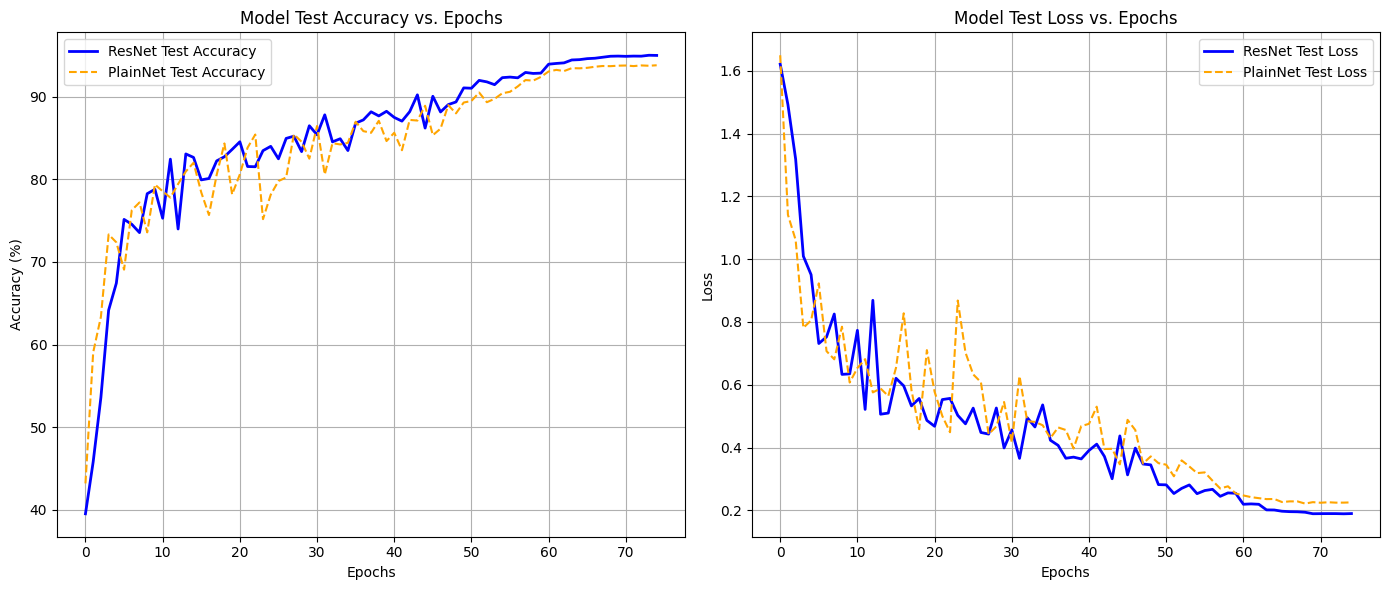

In [12]:
"""
CELL 8: RESULTS - VISUALIZING MODEL PERFORMANCE

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This cell uses the Matplotlib library to visualize and compare the performance of the ResNet-18
and PlainNet-18 models. It generates two side-by-side plots using the performance metrics that we
collected during the training process in the previous cell.
1. The first plot compares the test accuracy of both models over the 75 training epochs.
2. The second plot compares their test loss.
These plots are the primary visual evidence for the core conclusion of our project and will be
used in the final report to demonstrate the performance difference between the two architectures.
"""
# Create a figure to hold our subplots.
plt.figure(figsize=(14, 6))

# --- Plot 1: Test Accuracy Comparison ---
# Create the first subplot (1 row, 2 columns, first plot).
plt.subplot(1, 2, 1)
# Plot the ResNet's test accuracy history.
plt.plot(resnet_test_acc, label='ResNet Test Accuracy', color='blue', linewidth=2)
# Plot the PlainNet's test accuracy history on the same axes.
plt.plot(plainnet_test_acc, label='PlainNet Test Accuracy', color='orange', linestyle='--')
# Add labels and a title for clarity.
plt.title('Model Test Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

# --- Plot 2: Test Loss Comparison ---
# Create the second subplot.
plt.subplot(1, 2, 2)
# Plot the ResNet's test loss history.
plt.plot(resnet_test_loss, label='ResNet Test Loss', color='blue', linewidth=2)
# Plot the PlainNet's test loss history.
plt.plot(plainnet_test_loss, label='PlainNet Test Loss', color='orange', linestyle='--')
# Add labels and a title.
plt.title('Model Test Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# --- Finalize and Display the Plots ---
# Adjust subplot parameters for a tight layout.
plt.tight_layout()
# Render the plots to the screen.
plt.show()

In [13]:
"""
CELL 9: PROJECT EXTENSION - DETAILED PERFORMANCE ANALYSIS

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This cell extends our analysis beyond a single accuracy number. It provides a detailed, per-class
breakdown of each model's performance using a classification report from the Scikit-learn library.
To do this, we first define a helper function, `get_all_preds_and_labels`, which runs our trained
models over the entire test dataset to collect every single prediction. We then use these
predictions to generate two reports that show us the precision, recall, and F1-score for each of
the 10 classes in CIFAR-10. This allows us to identify if the models are struggling with specific
classes (e.g., distinguishing between 'cats' and 'dogs').
----
"""
# Import the classification_report function from Scikit-learn.
from sklearn.metrics import classification_report

# Helper function to iterate over the entire test set and collect all model predictions and true labels.
def get_all_preds_and_labels(model, loader, device):
    all_preds = []
    all_labels = []
    with torch.no_grad(): # Ensure gradients are not calculated.
        model.eval() # Set the model to evaluation mode.
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            # Get the index of the max log-probability as the prediction.
            _, predicted = torch.max(outputs, 1)
            # Extend our lists with the predictions and labels from this batch.
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# --- Generate and Print Reports ---

# Get all predictions for the ResNet model.
resnet_preds, all_labels = get_all_preds_and_labels(resnet, testloader, device)
# Get all predictions for the PlainNet model.
plainnet_preds, _ = get_all_preds_and_labels(plainnet, testloader, device)

# Print a formatted report for the ResNet-18.
print("="*50)
print("          ResNet-18 Classification Report")
print("="*50)
print(classification_report(all_labels, resnet_preds, target_names=classes))

# Print a formatted report for the PlainNet-18.
print("\n" + "="*50)
print("         PlainNet-18 Classification Report")
print("="*50)
print(classification_report(all_labels, plainnet_preds, target_names=classes))

          ResNet-18 Classification Report
              precision    recall  f1-score   support

       plane       0.95      0.96      0.95      1000
         car       0.97      0.98      0.97      1000
        bird       0.94      0.92      0.93      1000
         cat       0.90      0.90      0.90      1000
        deer       0.94      0.96      0.95      1000
         dog       0.91      0.92      0.91      1000
        frog       0.96      0.96      0.96      1000
       horse       0.98      0.97      0.97      1000
        ship       0.96      0.97      0.97      1000
       truck       0.97      0.96      0.97      1000

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000


         PlainNet-18 Classification Report
              precision    recall  f1-score   support

       plane       0.93      0.94      0.94      1000
         car       0.97      0.98      0.97   

In [14]:
"""
CELL 10: PROJECT EXTENSION - DESIGNING A REGULARIZED MODEL

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This cell addresses the overfitting observed in our initial experiment. It defines and instantiates
a new, heavily regularized version of our ResNet model. The goal is to create a model that
generalizes better, as measured by a smaller gap between training and testing accuracy.
Three key regularization techniques are implemented here:
1. A new `ResNetRegularized` class is defined. It is more flexible than the original, allowing us
   to customize the number of channels and add a dropout layer.
2. We instantiate this model with a "slimmer" architecture by halving the number of channels at
   each stage, thereby reducing the model's complexity.
3. We add a 50% dropout layer right before the final classifier, forcing the network to learn more
   robust features.
4. We create a new optimizer for this model with double the strength of L2 regularization
   (weight decay), which penalizes large weights to prevent the model from becoming too complex.

"""

# 1. Define a new, flexible ResNet class that accepts channel sizes and a dropout rate.
class ResNetRegularized(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, channels=[64, 128, 256, 512], dropout_rate=0.0):
        super(ResNetRegularized, self).__init__()
        self.in_planes = channels[0]

        # The architecture is largely the same, but now uses the flexible 'channels' list.
        self.conv1 = nn.Conv2d(3, channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels[0])
        self.layer1 = self._make_layer(block, channels[0], num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, channels[1], num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, channels[2], num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, channels[3], num_blocks[3], stride=2)
        # Add a dropout layer, which will be applied in the forward pass.
        self.dropout = nn.Dropout(p=dropout_rate)
        self.linear = nn.Linear(channels[3]*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out); out = self.layer2(out); out = self.layer3(out); out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        # Apply dropout right before the final classification layer. This is a common practice.
        out = self.dropout(out)
        out = self.linear(out)
        return out

# 2. Instantiate the new model with our chosen regularization techniques.
resnet_regularized = ResNetRegularized(
    BasicBlock,
    [2, 2, 2, 2],
    channels=[32, 64, 128, 256],  # Technique 1: Reduced model complexity (slimmer channels).
    dropout_rate=0.5                # Technique 2: 50% Dropout.
).to(device)

# 3. Set up the optimizer with a stronger L2 penalty.
optimizer_reg = optim.SGD(
    resnet_regularized.parameters(),
    lr=0.1,
    momentum=0.9,
    weight_decay=1e-3  # Technique 3: Increased L2 regularization (weight decay).
)
scheduler_reg = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer_reg, T_max=75)

# Print a confirmation message summarizing the new model's configuration.
print("Successfully created a new regularized ResNet model with:")
print("- Slimmer architecture (fewer channels)")
print("- 50% Dropout before the final layer")
print("- Stronger L2 regularization (weight_decay=0.001)")

Successfully created a new regularized ResNet model with:
- Slimmer architecture (fewer channels)
- 50% Dropout before the final layer
- Stronger L2 regularization (weight_decay=0.001)


In [15]:
"""
CELL 11: PROJECT EXTENSION - TRAINING THE REGULARIZED MODEL

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This cell executes the training and evaluation loop for our new `resnet_regularized` model. The
process is identical to the one used for the baseline models to ensure a fair comparison. It uses
the same reusable `train()` and `test()` functions defined earlier. The primary difference is that
we are now passing in our new, regularized model and its corresponding optimizer with the stronger
L2 penalty. All performance metrics (loss and accuracy) for this new model are stored in separate
lists (e.g., `reg_train_acc`) so that we can directly compare them against the original ResNet in
the next and final step.

"""

# Initialize new lists to store the performance metrics specifically for the regularized model.
reg_train_loss, reg_train_acc = [], []
reg_test_loss, reg_test_acc = [], []

# --- Main Training Loop for the Regularized Model ---
print("--- Training Regularized ResNet (Slim + Dropout + Stronger L2) ---")
# Record the start time.
start_time = time.time()
# Loop for the predefined number of epochs.
for epoch in range(75):
    # Call the same reusable train and test functions, but pass in the new model and its optimizer.
    train_loss, train_acc = train(epoch, resnet_regularized, optimizer_reg, scheduler_reg, trainloader, criterion, device)
    test_loss, test_acc = test(epoch, resnet_regularized, testloader, criterion, device)

    # Update the learning rate scheduler.
    scheduler_reg.step()

    # Append the collected metrics to our new lists for the regularized model.
    reg_train_loss.append(train_loss)
    reg_train_acc.append(train_acc)
    reg_test_loss.append(test_loss)
    reg_test_acc.append(test_acc)

# Record the end time and print the total training duration.
end_time = time.time()
print(f"Regularized ResNet Training Time: {end_time - start_time:.2f}s")

--- Training Regularized ResNet (Slim + Dropout + Stronger L2) ---

Epoch: 0
Train Loss: 1.875 | Acc: 31.548% (15774/50000)
Test Loss: 1.534 | Acc: 41.600% (4160/10000)

Epoch: 1
Train Loss: 1.450 | Acc: 46.828% (23414/50000)
Test Loss: 1.379 | Acc: 49.750% (4975/10000)

Epoch: 2
Train Loss: 1.125 | Acc: 60.106% (30053/50000)
Test Loss: 1.157 | Acc: 59.920% (5992/10000)

Epoch: 3
Train Loss: 0.919 | Acc: 68.132% (34066/50000)
Test Loss: 0.891 | Acc: 69.170% (6917/10000)

Epoch: 4
Train Loss: 0.815 | Acc: 72.214% (36107/50000)
Test Loss: 1.531 | Acc: 58.370% (5837/10000)

Epoch: 5
Train Loss: 0.770 | Acc: 73.666% (36833/50000)
Test Loss: 1.506 | Acc: 55.880% (5588/10000)

Epoch: 6
Train Loss: 0.730 | Acc: 75.456% (37728/50000)
Test Loss: 0.885 | Acc: 71.710% (7171/10000)

Epoch: 7
Train Loss: 0.705 | Acc: 76.186% (38093/50000)
Test Loss: 0.826 | Acc: 72.350% (7235/10000)

Epoch: 8
Train Loss: 0.680 | Acc: 77.144% (38572/50000)
Test Loss: 0.921 | Acc: 70.110% (7011/10000)

Epoch: 9
Train

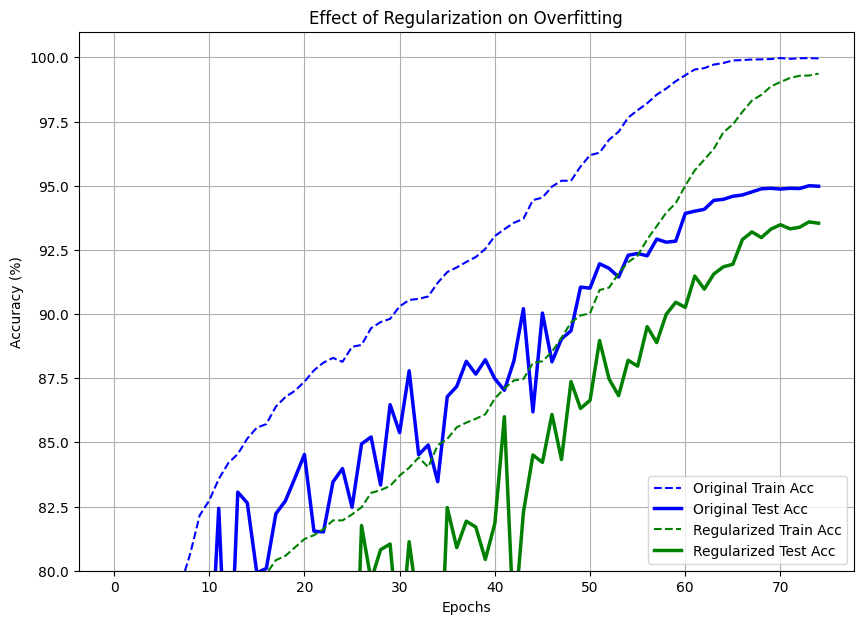

In [17]:
"""
CELL 12: PROJECT EXTENSION - VISUALIZING THE IMPACT OF REGULARIZATION

----------------------------------------------------------------------------------------------------
WHAT THIS CELL DOES:
This is the final analysis step. This cell generates a single, comprehensive plot that directly
compares the performance of our original ResNet-18 model against our new, regularized ResNet.
It plots four lines on the same axes:
1. The training accuracy of the original model.
2. The testing accuracy of the original model.
3. The training accuracy of the new, regularized model.
4. The testing accuracy of the new, regularized model.
By visualizing the gap between the training (dashed) and testing (solid) lines for both models,
this plot provides definitive visual evidence of our success in combating overfitting and serves as
the key result for the project extension.

"""

# Create a figure for our comparison plot.
plt.figure(figsize=(10, 7))

# --- Plotting the Original (Overfit) Model ---
# Plot the training accuracy (dashed line) for the original ResNet.
plt.plot(resnet_train_acc, label='Original Train Acc', color='blue', linestyle='--')
# Plot the testing accuracy (solid line) for the original ResNet.
plt.plot(resnet_test_acc, label='Original Test Acc', color='blue', linewidth=2.5)

# --- Plotting the New (Regularized) Model ---
# Plot the training accuracy (dashed line) for the new regularized model.
plt.plot(reg_train_acc, label='Regularized Train Acc', color='green', linestyle='--')
# Plot the testing accuracy (solid line) for the new regularized model.
plt.plot(reg_test_acc, label='Regularized Test Acc', color='green', linewidth=2.5)

# --- Finalizing the Plot ---
# Add a title and labels for clarity.
plt.title('Effect of Regularization on Overfitting')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
# Add a legend to the lower right corner to identify the lines.
plt.legend(loc='lower right')
# Add a grid for easier reading of values.
plt.grid(True)
# Zoom in on the most relevant part of the accuracy range (80% to 100%).
plt.ylim(80, 101)
# Render the final plot to the screen.
plt.show()